In [2]:
import sys
import os
import pathlib
import datetime
import numpy as np
import pandas as pd
import scipy.stats as sp
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.patches as mpatches
import pingouin as pg
pd.options.display.max_columns = 150
%matplotlib inline
sns.set()
pd.set_option('display.max_rows', 250)
sns.set_style("whitegrid")
from scipy.stats import ttest_ind
from statsmodels.stats.anova import AnovaRM
import warnings
warnings.filterwarnings('ignore')
path = "../models"
if not path in sys.path:
    sys.path.append(path)
%reload_ext autoreload
%autoreload 1
from statannot import add_stat_annotation
import patsy
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf
import statsmodels.api as sm
from statsmodels.stats.anova import AnovaRM
from statsmodels.regression.mixed_linear_model import MixedLMResults

import dishpill_models

/opt/conda/lib/python3.8/site-packages/outdated/utils.py:14: OutdatedPackageWarning: The package pingouin is out of date. Your version is 0.3.11, the latest is 0.4.0.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  return warn(


In [3]:
def group_data(dataframe, tag_list):
    print("Chosen tags are", tag_list)
    df = dataframe
    mask = df['tag'].isin(tag_list)
    df = df[mask]
    group = df['tag'].str.contains('ctl', case = False)
    df['group'] = group.astype(int)
    halfmask = df['elapse_seconds']>t1
    df['elapse_minute_rounded'] = np.int32(df['elapse_seconds'] / 60.)
    df['20_sec'] = np.int32(df['elapse_seconds'] / 20.)
    df.loc[:,'half'] = halfmask
    df["half"] = df["half"].astype(int)
    
    #df = df[df['hit_count']>0]
    df
    return df

In [4]:
# use to this calculate probability and ln probability of hit_counts and shape data per 
# group to plot as heatmap
def hmShape(hmdf, groupNum):
    hmdfmask = ((hmdf['group'] == groupNum) & (hmdf['elapse_minute_rounded'] != 20))
    maskedhmdf = hmdf[hmdfmask]
    
    #This parts generates counts of the number of hits in a minute and works this out in log odds format (decibals).
    hmName = maskedhmdf.groupby(['elapse_minute_rounded', 'hit_count']).agg({'count':'sum'})                                                                      
    hmName = hmName.unstack(level=0)
    hchmnamecopy= hmName[['count']].copy()
    hchmname = hchmnamecopy.fillna(0)
    hchmname =hchmname.sort_values(by='hit_count', ascending=False)
    hchmname = hchmname.replace(0, 1)
    hchmname = hchmname.div(hchmname.sum(axis=0), axis=1)
    hchmname = ((1/hchmname)-1)
    hchmname[hchmname.columns[0:20]] = 10*np.log10(hchmname[hchmname.columns[0:20]])
    hchmname = hchmname.replace('inf', 0)
    hchmname = hchmname.fillna(0)
    
    #generates array cdf of hit counts
    cdfdfmask = ((hmdf['group'] == groupNum) & (hmdf['elapse_minute_rounded'] != 20))
    maskedcdfhmdf = hmdf[cdfdfmask]
    cdfhc = maskedcdfhmdf.groupby(['hit_count']).agg({'count':'sum'}) 
    cdfhc = cdfhc/cdfhc.sum()
    cdfhc = np.cumsum(cdfhc)
    cdfhc = cdfhc.reset_index()

    return hchmname, cdfhc


In [5]:
df = pd.read_pickle('in_vitro_cells_sentience_HEK_control.pkl')

In [6]:
newdf = df
idlist = []
datelist = []
grouplist = []
for i, row in newdf.iterrows():
    if newdf.loc[i, 'group'] not in grouplist:
        idlist = []
        datelist = []
        grouplist.append(newdf.loc[i, 'group'])
        testday = 0
        newdf.loc[i, 'test_day'] = testday
    else:
        if newdf.loc[i, 'chip_id'] not in idlist:
            datelist = []
            testday = 0
            idlist.append(newdf.loc[i, 'chip_id'])
            newdf.loc[i, 'test_day'] = testday
            datelist.append(newdf.loc[i, 'date'])
        elif newdf.loc[i, 'chip_id']  in idlist:
            if newdf.loc[i, 'date'] in datelist:
                 newdf.loc[i, 'test_day'] = testday
            else:
                datelist.append(newdf.loc[i, 'date'])
                testday += 1
                newdf.loc[i, 'test_day'] = testday
            
        
    #print(datelist)

In [9]:
#normalises only by group
filtdf = df.groupby(['group', 'tag', 'chip_id', 'test_day', 'session_num', 'half', "control", 'elapse_minute_rounded']).mean()
data = filtdf.reset_index()
data = data.groupby(['group', 'tag', 'chip_id', 'test_day', 'half', 'session_num', "control"]).mean()
data = data[['hit_count']].copy()
data = data.unstack(level=6)
data=data.sort_values(by=["group", "tag", "chip_id", "test_day", "half",])
data[('hit_count', 1)] = data[('hit_count', 1)].fillna(method='ffill', inplace=False)
data = data.dropna()
data["normhc"] = ((data[('hit_count', 0)] - data[('hit_count', 1)]) / data[('hit_count', 1)] ) *100
data = data.reset_index()

data['session_num']= np.where((data['test_day'] == 1) & (data['session_num'] == 0), 3, data['session_num']) 
data['session_num']= np.where((data['test_day'] == 1)& (data['session_num'] == 1), 4, data['session_num']) 
data['session_num']= np.where((data['test_day'] == 1)& (data['session_num'] == 2), 5, data['session_num']) 
data['session_num']= np.where((data['test_day'] == 2)& (data['session_num'] == 0), 6, data['session_num']) 
data['session_num']= np.where((data['test_day'] == 2)& (data['session_num'] == 1), 7, data['session_num']) 
data['session_num']= np.where((data['test_day'] == 2)& (data['session_num'] == 2), 8, data['session_num']) 


data["id"] = ((data['group']).astype(str) + (data['chip_id']).astype(str)) + ((data['session_num']).astype(str))
data = data[(data.group != 4)]
#data = data[(data.test_day != 3)]


data[:150]
#data.chip_id.unique()

group                              tag chip_id test_day half  \
control                                                                
0           0            GFP__rate_code_reseed   11597      1.0    0   
1           0            GFP__rate_code_reseed   11597      1.0    0   
2           0            GFP__rate_code_reseed   11597      1.0    0   
3           0            GFP__rate_code_reseed   11597      1.0    1   
4           0            GFP__rate_code_reseed   11597      1.0    1   
5           0            GFP__rate_code_reseed   11597      1.0    1   
6           0            GFP__rate_code_reseed   11597      2.0    0   
7           0            GFP__rate_code_reseed   11597      2.0    0   
8           0            GFP__rate_code_reseed   11597      2.0    0   
9           0            GFP__rate_code_reseed   11597      2.0    1   
10          0            GFP__rate_code_reseed   11597      2.0    1   
11          0            GFP__rate_code_reseed   11597      2.0    1   
12          0            GFP__rate_code_reseed   11609      0.0    0   
13          0            GFP__rate_code_reseed   11609      0.0    0   
14          0            GFP__rate_code_reseed   11609      0.0    0   
15          0            GFP__rate_code_reseed   11609      0.0    1   
16          0            GFP__rate_code_reseed   11609      0.0    1   
17          0            GFP__rate_code_reseed   11609      0.0    1   
18          0            GFP__rate_code_reseed   11609      1.0    0   
19          0            GFP__rate_code_reseed   11609      1.0    0   
20          0            GFP__rate_code_reseed   11609      1.0    0   
21          0            GFP__rate_code_reseed   11609      1.0    1   
22          0            GFP__rate_code_reseed   11609      1.0    1   
23          0            GFP__rate_code_reseed   11609      1.0    1   
24          0  GFP_low_test_rate_code_random_3   11597      0.0    0   
25          0  GFP_low_test_rate_code_random_3   11597      0.0    0   
26          0  GFP_low_test_rate_code_random_3   11597      0.0    0   
27          0  GFP_low_test_rate_code_random_3   11597      0.0    1   
28          0  GFP_low_test_rate_code_random_3   11597      0.0    1   
29          0  GFP_low_test_rate_code_random_3   11597      0.0    1   
30          0  GFP_low_test_rate_code_random_3   11613      0.0    0   
31          0  GFP_low_test_rate_code_random_3   11613      0.0    0   
32          0  GFP_low_test_rate_code_random_3   11613      0.0    0   
33          0  GFP_low_test_rate_code_random_3   11613      0.0    1   
34          0  GFP_low_test_rate_code_random_3   11613      0.0    1   
35          0  GFP_low_test_rate_code_random_3   11613      0.0    1   
36          0  GFP_low_test_rate_code_random_3   11615      0.0    0   
37          0  GFP_low_test_rate_code_random_3   11615      0.0    0   
38          0  GFP_low_test_rate_code_random_3   11615      0.0    0   
39          0  GFP_low_test_rate_code_random_3   11615      0.0    1   
40          0  GFP_low_test_rate_code_random_3   11615      0.0    1   
41          0  GFP_low_test_rate_code_random_3   11615      0.0    1   
42          0  GFP_low_test_rate_code_random_3   11615      1.0    0   
43          0  GFP_low_test_rate_code_random_3   11615      1.0    0   
44          0  GFP_low_test_rate_code_random_3   11615      1.0    0   
45          0  GFP_low_test_rate_code_random_3   11615      1.0    1   
46          0  GFP_low_test_rate_code_random_3   11615      1.0    1   
47          0  GFP_low_test_rate_code_random_3   11615      1.0    1   
48          0  GFP_low_test_rate_code_random_3   11618      0.0    0   
49          0  GFP_low_test_rate_code_random_3   11618      0.0    0   
50          0  GFP_low_test_rate_code_random_3   11618      0.0    0   
51          0  GFP_low_test_rate_code_random_3   11618      0.0    1   
52          0  GFP_low_test_rate_code_random_3   11618      0.0    1   
53          0  GFP_low_test_rate_code_random_3  

In [10]:
aov = pg.mixed_anova(data=data, dv=('normhc'), subject=('id'), between='group', 
                     within= 'half',
                     correction = True, effsize='np2')
pg.print_table(aov)


ANOVA SUMMARY

Source              SS    DF1    DF2         MS       F    p-unc    np2      eps
-----------  ---------  -----  -----  ---------  ------  -------  -----  -------
group        27794.239      2    237  13897.119   3.052    0.049  0.025  nan
half         63857.232      1    237  63857.232  27.008    0.000  0.102    1.000
Interaction  27628.951      2    237  13814.476   5.843    0.003  0.047  nan



In [11]:
Stimulus = data[(data.group == 0)]  
Silent = data[(data.group == 1)] 
Open = data[(data.group == 2)] 
Day0 = data[(data.test_day == 0)]  
Day1 = data[(data.test_day == 1)]  
Day2 = data[(data.test_day == 2)] 

Half0 = data[(data.half == 0)] 
Half1 = data[(data.half == 1)] 

Stimulusday0 = data[(data.group == 0)& (data.test_day == 0)] 
Stimulusday1 = data[(data.group == 0)& (data.test_day == 1)] 
Stimulusday2 = data[(data.group == 0)& (data.test_day == 2)] 


Silentday0 = data[(data.group == 1)& (data.test_day == 0)] 
Silentday1 = data[(data.group == 1)& (data.test_day == 1)] 
Silentday2 = data[(data.group == 1)& (data.test_day == 2)] 

In [12]:
aov = pg.anova(data=Half0, dv=('normhc'), between='group', detailed = True)
pg.print_table(aov)


ANOVA SUMMARY

Source             SS    DF        MS        F    p-unc      np2
--------  -----------  ----  --------  -------  -------  -------
group        2778.322     2  1389.161    0.405    0.667    0.002
Within    1518296.169   443  3427.305  nan      nan      nan



In [13]:
aov = pg.anova(data=Half1, dv=('normhc'), between='group', detailed = True)
pg.print_table(aov)


ANOVA SUMMARY

Source             SS    DF         MS        F    p-unc      np2
--------  -----------  ----  ---------  -------  -------  -------
group       84411.844     2  42205.922   14.107    0.000    0.060
Within    1322386.772   442   2991.825  nan      nan      nan



In [151]:
pg.pairwise_gameshowell(data =Half1, dv='normhc', between='group').round(3)

A  B  mean(A)  mean(B)    diff     se      T       df   pval  hedges
0  0  1   44.583   18.682  25.901  5.825  4.446  279.739  0.001   0.493
1  0  2   44.583   14.374  30.209  6.652  4.541  153.166  0.001   0.591
2  1  2   18.682   14.374   4.309  7.074  0.609  163.673  0.796   0.089

In [152]:
Stimulus0 = data[(data.group == 0)& (data.half == 0)] 
Stimulus0 = Stimulus0[1:]
Stimulus1 = data[(data.group == 0)& (data.half == 1)] 
stats.ttest_rel(Stimulus0['normhc'], Stimulus1['normhc'])

Ttest_relResult(statistic=-8.220779523999093, pvalue=1.1508587291831533e-14)

In [153]:
Silent0 = data[(data.group == 1)& (data.half == 0)] 
#Stimulus0 = Stimulus0[1:]
Silent1 = data[(data.group == 1)& (data.half == 1)] 
stats.ttest_rel(Silent0['normhc'], Silent1['normhc'])


Ttest_relResult(statistic=-0.6661864783615276, pvalue=0.5065813376558936)

In [154]:
Open0 = data[(data.group == 2)& (data.half == 0)] 
#Stimulus0 = Stimulus0[1:]
Open1 = data[(data.group == 2)& (data.half == 1)] 
stats.ttest_rel(Open0['normhc'], Open1['normhc'])


Ttest_relResult(statistic=-0.874618782336707, pvalue=0.3845369394628624)

In [155]:
d = {'group': data[(      'group', '')], 'score': data[(     'normhc', '')], 
     'id': data[(         'id', '')], 'test_day': data[(   'test_day', '')], 
     'session_num': data[('session_num', '')], 'half': data[(       'half', '')]}
ad = pd.DataFrame(data=d)
ad.columns
ad['stim']= np.where((ad['group'] == 0), 1, 0) 
ad['sil']= np.where((ad['group'] == 1), 1, 0) 
ad['nf']= np.where((ad['group'] == 2), 1, 0) 

In [156]:
labels = data.group.unique()
x_pos = np.arange(len(labels))
x = ad['group']
y = ad['score']
hue = ad['half']
sns.set(style="darkgrid")
ax = sns.boxplot(data=ad, x=x, y=y, hue=hue, palette="Set2", showfliers=False, showmeans = True, 
                 meanprops={"markerfacecolor":"black", 
                       "markeredgecolor":"black",
                      "markersize":"5"})
ax.set_xticks(x_pos)
ax.set_xticklabels(("Cortical \n cells", "HEK \n control", "Media \n control"))
#ax.set_title('Pong Performance By \n Condition & Time')
ax.set_ylabel('Δ Rally Length vs Rest (%)')
ax.set_xlabel('Group')
ax.grid(False)
ax.legend([0, 1], ["0-5", "6-20"])
L = plt.legend(loc='lower left', bbox_to_anchor=(-0.2, -0.5), title = "Minutes", borderaxespad=0.1, frameon=False)
L.get_texts()[0].set_text('0-5')
L.get_texts()[1].set_text('6-20')

y, h, col = 170, 5.6, 'k'
x00, x01 = -.2, .2
x10, x11 = .8, 1.2
x20, x21 = 1.8, 2.2
#Plot t-test between groups
plt.plot([x00, x00, x01, x01], [y, y+h, y+h, y], lw=1.5, c=col)
plt.text(((x00 + x01)/2), y+ h, "****", ha='center', va='bottom', color=col, fontsize=8)
#Plot differences between groups time 2
plt.text(x11, y, "###", ha='center', va='bottom', color=col,  fontsize=8)

plt.text(x21, y, "###", ha='center', va='bottom', color=col, fontsize=8)



ax.set_ylim([-80, 200])
sns.set(rc={'figure.figsize':(3,3)})

plt.savefig('/home/jovyan/work/dishpill/Analysis/Plots/HEKCTL_normhc_sig.pdf', bbox_inches='tight')  


In [29]:
#normalises only by group for aces
filtdf = df.groupby(['group', 'tag', 'chip_id', 'test_day', 'session_num', 'half', "control", 'elapse_minute_rounded']).mean()
data = filtdf.reset_index()
data = data.groupby(['group', 'tag', 'chip_id', 'test_day', 'half', 'session_num', "control"]).mean()
data = data[['ace']].copy()
data = data.unstack(level=6)
data=data.sort_values(by=["group", "tag", "chip_id", "test_day", "half",])
data[('ace', 1)] = data[('ace', 1)].fillna(method='ffill', inplace=False)
data = data.dropna()
data["normace"] = (data[('ace', 0)] - data[('ace', 1)]) *100#/ data[('ace', 1)] ) *100
data = data.reset_index()


data['session_num']= np.where((data['test_day'] == 1) & (data['session_num'] == 0), 3, data['session_num']) 
data['session_num']= np.where((data['test_day'] == 1)& (data['session_num'] == 1), 4, data['session_num']) 
data['session_num']= np.where((data['test_day'] == 1)& (data['session_num'] == 2), 5, data['session_num']) 
data['session_num']= np.where((data['test_day'] == 2)& (data['session_num'] == 0), 6, data['session_num']) 
data['session_num']= np.where((data['test_day'] == 2)& (data['session_num'] == 1), 7, data['session_num']) 
data['session_num']= np.where((data['test_day'] == 2)& (data['session_num'] == 2), 8, data['session_num']) 

data["id"] = ((data['group']).astype(str) + (data['chip_id']).astype(str)) + ((data['session_num']).astype(str))

data = data[(data.group != 4)]

data[:150]
#data.chip_id.unique()

group                              tag chip_id test_day half  \
control                                                                
0           0            GFP__rate_code_reseed   11597      1.0    0   
1           0            GFP__rate_code_reseed   11597      1.0    0   
2           0            GFP__rate_code_reseed   11597      1.0    0   
3           0            GFP__rate_code_reseed   11597      1.0    1   
4           0            GFP__rate_code_reseed   11597      1.0    1   
5           0            GFP__rate_code_reseed   11597      1.0    1   
6           0            GFP__rate_code_reseed   11597      2.0    0   
7           0            GFP__rate_code_reseed   11597      2.0    0   
8           0            GFP__rate_code_reseed   11597      2.0    0   
9           0            GFP__rate_code_reseed   11597      2.0    1   
10          0            GFP__rate_code_reseed   11597      2.0    1   
11          0            GFP__rate_code_reseed   11597      2.0    1   
12          0            GFP__rate_code_reseed   11609      0.0    0   
13          0            GFP__rate_code_reseed   11609      0.0    0   
14          0            GFP__rate_code_reseed   11609      0.0    0   
15          0            GFP__rate_code_reseed   11609      0.0    1   
16          0            GFP__rate_code_reseed   11609      0.0    1   
17          0            GFP__rate_code_reseed   11609      0.0    1   
18          0            GFP__rate_code_reseed   11609      1.0    0   
19          0            GFP__rate_code_reseed   11609      1.0    0   
20          0            GFP__rate_code_reseed   11609      1.0    0   
21          0            GFP__rate_code_reseed   11609      1.0    1   
22          0            GFP__rate_code_reseed   11609      1.0    1   
23          0            GFP__rate_code_reseed   11609      1.0    1   
24          0  GFP_low_test_rate_code_random_3   11597      0.0    0   
25          0  GFP_low_test_rate_code_random_3   11597      0.0    0   
26          0  GFP_low_test_rate_code_random_3   11597      0.0    0   
27          0  GFP_low_test_rate_code_random_3   11597      0.0    1   
28          0  GFP_low_test_rate_code_random_3   11597      0.0    1   
29          0  GFP_low_test_rate_code_random_3   11597      0.0    1   
30          0  GFP_low_test_rate_code_random_3   11613      0.0    0   
31          0  GFP_low_test_rate_code_random_3   11613      0.0    0   
32          0  GFP_low_test_rate_code_random_3   11613      0.0    0   
33          0  GFP_low_test_rate_code_random_3   11613      0.0    1   
34          0  GFP_low_test_rate_code_random_3   11613      0.0    1   
35          0  GFP_low_test_rate_code_random_3   11613      0.0    1   
36          0  GFP_low_test_rate_code_random_3   11615      0.0    0   
37          0  GFP_low_test_rate_code_random_3   11615      0.0    0   
38          0  GFP_low_test_rate_code_random_3   11615      0.0    0   
39          0  GFP_low_test_rate_code_random_3   11615      0.0    1   
40          0  GFP_low_test_rate_code_random_3   11615      0.0    1   
41          0  GFP_low_test_rate_code_random_3   11615      0.0    1   
42          0  GFP_low_test_rate_code_random_3   11615      1.0    0   
43          0  GFP_low_test_rate_code_random_3   11615      1.0    0   
44          0  GFP_low_test_rate_code_random_3   11615      1.0    0   
45          0  GFP_low_test_rate_code_random_3   11615      1.0    1   
46          0  GFP_low_test_rate_code_random_3   11615      1.0    1   
47          0  GFP_low_test_rate_code_random_3   11615      1.0    1   
48          0  GFP_low_test_rate_code_random_3   11618      0.0    0   
49          0  GFP_low_test_rate_code_random_3   11618      0.0    0   
50          0  GFP_low_test_rate_code_random_3   11618      0.0    0   
51          0  GFP_low_test_rate_code_random_3   11618      0.0    1   
52          0  GFP_low_test_rate_code_random_3   11618      0.0    1   
53          0  GFP_low_test_rate_code_random_3  

In [30]:
aov = pg.mixed_anova(data=data, dv=('normace'), subject=('id'), between='group', 
                     within= 'half',
                     correction = True, effsize='np2')
pg.print_table(aov)


ANOVA SUMMARY

Source             SS    DF1    DF2        MS       F    p-unc    np2      eps
-----------  --------  -----  -----  --------  ------  -------  -----  -------
group        3912.384      2    237  1956.192  10.036    0.000  0.078  nan
half          378.925      1    237   378.925   6.732    0.010  0.028    1.000
Interaction   517.433      2    237   258.716   4.596    0.011  0.037  nan



In [28]:
Half0 = data[(data.half == 0)]
Half1 = data[(data.half == 1)]
Stimulus = data[(data.group == 0)]  
Silent = data[(data.group == 1)] 
Open = data[(data.group == 2)] 
Day0 = data[(data.test_day == 0)]  
Day1 = data[(data.test_day == 1)]  
Day2 = data[(data.test_day == 2)] 


Stimulusday0 = data[(data.group == 0)& (data.test_day == 0)] 
Stimulusday1 = data[(data.group == 0)& (data.test_day == 1)] 
Stimulusday2 = data[(data.group == 0)& (data.test_day == 2)] 


Silentday0 = data[(data.group == 1)& (data.test_day == 0)] 
Silentday1 = data[(data.group == 1)& (data.test_day == 1)] 
Silentday2 = data[(data.group == 1)& (data.test_day == 2)] 

In [17]:
aov = pg.anova(data=Half0, dv=('normace'), between='group', detailed = True)
pg.print_table(aov)


ANOVA SUMMARY

Source           SS    DF       MS        F    p-unc      np2
--------  ---------  ----  -------  -------  -------  -------
group      1688.467     2  844.234    5.060    0.007    0.022
Within    73916.919   443  166.855  nan      nan      nan



In [18]:
pg.pairwise_gameshowell(data =Half0, dv='normace', between='group').round(3)

A  B  mean(A)  mean(B)   diff     se      T       df   pval  hedges
0  0  1   -5.888   -2.410 -3.479  1.430 -2.433  241.772  0.041  -0.270
1  0  2   -5.888   -1.422 -4.466  1.649 -2.709  132.140  0.021  -0.352
2  1  2   -2.410   -1.422 -0.988  1.837 -0.538  164.491  0.837  -0.078

In [19]:
aov = pg.anova(data=Half1, dv=('normace'), between='group', detailed = True)
pg.print_table(aov)


ANOVA SUMMARY

Source           SS    DF        MS        F    p-unc      np2
--------  ---------  ----  --------  -------  -------  -------
group      5656.476     2  2828.238   26.297    0.000    0.106
Within    47536.928   442   107.550  nan      nan      nan



In [20]:
pg.pairwise_gameshowell(data =Half1, dv='normace', between='group').round(3)

A  B  mean(A)  mean(B)   diff     se      T       df   pval  hedges
0  0  1   -8.953   -2.741 -6.212  1.054 -5.894  292.584  0.001  -0.654
1  0  2   -8.953   -0.617 -8.336  1.405 -5.931  129.919  0.001  -0.772
2  1  2   -2.741   -0.617 -2.124  1.452 -1.463  137.530  0.313  -0.213

In [164]:
Stimulus0 = data[(data.group == 0)& (data.half == 0)] 
Stimulus0 = Stimulus0[1:]
Stimulus1 = data[(data.group == 0)& (data.half == 1)] 
stats.ttest_rel(Stimulus0['normace'], Stimulus1['normace'])

Ttest_relResult(statistic=3.401867352247458, pvalue=0.0007805208337704911)

In [165]:

Stimulus1 = data[(data.group == 0)& (data.half == 1)] 
stats.ttest_rel(Stimulus0['normace'], Stimulus1['normace'])
Silent0 = data[(data.group == 1)& (data.half == 0)] 
#Silent0 = Silent0[1:]
Silent1 = data[(data.group == 1)& (data.half == 1)] 
stats.ttest_rel(Silent0['normace'], Silent1['normace'])


Ttest_relResult(statistic=0.24700182725068434, pvalue=0.8053324303488938)

In [166]:
Open0 = data[(data.group == 2)& (data.half == 0)] 
#Silent0 = Silent0[1:]
Open1 = data[(data.group == 2)& (data.half == 1)] 
stats.ttest_rel(Open0['normace'], Open1['normace'])

Ttest_relResult(statistic=-0.5222620720147196, pvalue=0.6030068790225445)

In [167]:
pg.pairwise_gameshowell(data =Half1, dv='normace', between='group').round(3)

A  B  mean(A)  mean(B)   diff     se      T       df   pval  hedges
0  0  1   -8.953   -2.741 -6.212  1.054 -5.894  292.584  0.001  -0.654
1  0  2   -8.953   -0.617 -8.336  1.405 -5.931  129.919  0.001  -0.772
2  1  2   -2.741   -0.617 -2.124  1.452 -1.463  137.530  0.313  -0.213

In [168]:
d = {'group': data[(      'group', '')], 'score': data[(     'normace', '')], 
     'id': data[(         'id', '')], 'test_day': data[(   'test_day', '')], 
     'session_num': data[('session_num', '')], 'half': data[(       'half', '')]}
ad = pd.DataFrame(data=d)
ad.columns
ad['stim']= np.where((ad['group'] == 0), 1, 0) 
ad['sil']= np.where((ad['group'] == 1), 1, 0) 
ad['nf']= np.where((ad['group'] == 2), 1, 0) 

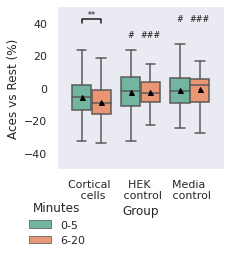

In [169]:
labels = data.group.unique()
x_pos = np.arange(len(labels))
x = ad['group']
y = ad['score']
hue = ad['half']
sns.set(style="darkgrid")
ax = sns.boxplot(data=ad, x=x, y=y, hue=hue, palette="Set2", showfliers=False, showmeans = True, 
                 meanprops={"markerfacecolor":"black", 
                       "markeredgecolor":"black",
                      "markersize":"5"})
ax.set_xticks(x_pos)
ax.set_xticklabels(("Cortical \n cells", "HEK \n control", "Media \n control"))
#ax.set_title('Pong Performance By \n Condition & Time')
ax.set_ylabel('Aces vs Rest (%)')
ax.set_xlabel('Group')
ax.grid(False)
ax.legend([0, 1], ["0-5", "6-20"])
L = plt.legend(loc='lower left', bbox_to_anchor=(-0.2, -0.5), title = "Minutes", borderaxespad=0.1, frameon=False)
L.get_texts()[0].set_text('0-5')
L.get_texts()[1].set_text('6-20')

y, h, col = 40, 2, 'k'
x00, x01 = -.2, .2
x10, x11 = .8, 1.2
x20, x21 = 1.8, 2.2
#Plot t-test between groups
plt.plot([x00, x00, x01, x01], [y, y+h, y+h, y], lw=1.5, c=col)
plt.text(((x00 + x01)/2), y+ h, "**", ha='center', va='bottom', color=col, fontsize=8)

#Plot differences between groups
plt.text(x11, y-10, "###", ha='center', va='bottom', color=col,  fontsize=8)

plt.text(x21, y, "###", ha='center', va='bottom', color=col, fontsize=8)
plt.text(x20, y, "#", ha='center', va='bottom', color=col, fontsize=8)
plt.text(x10, y-10, "#", ha='center', va='bottom', color=col, fontsize=8)


# Plot extra legend
#plt.text(4.4, 1.38, "#=p<0.01 \n vs Stimulus", ha='center', va='bottom', color=col)
#plt.text(4.4, 1.15, "#=p<0.05 \n vs Stimulus", ha='center', va='bottom', color=col)
#plt.text(4.4, .92, "%%=p<0.01  \n vs Silent", ha='center', va='bottom', color=col)
#plt.text(4.4, .69, "%=p<0.05  \n vs Silent", ha='center', va='bottom', color=col)

ax.set_ylim([-50, 50])
sns.set(rc={'figure.figsize':(3,3)})

plt.savefig('/home/jovyan/work/dishpill/Analysis/Plots/HEKCTL_ace_sig.pdf', bbox_inches='tight')

In [31]:
#normalises only by group for long_rally
filtdf = df.groupby(['group', 'tag', 'chip_id', 'test_day', 'session_num', 'half', "control", 'elapse_minute_rounded']).mean()
data = filtdf.reset_index()
data = data.groupby(['group', 'tag', 'chip_id', 'test_day', 'half', 'session_num', "control"]).mean()
data = data[['long_rally']].copy()
data = data.unstack(level=6)
data=data.sort_values(by=["group", "tag", "chip_id", "test_day", "half",])
data[('long_rally', 1)] = data[('long_rally', 1)].fillna(method='ffill', inplace=False)
data = data.dropna()
#data['long_rally', 0]= np.where((data['long_rally', 0] == 0.000000), 0.000001, data['long_rally', 0]) 
#data['long_rally', 1]= np.where((data['long_rally', 1] == 0.000000), 0.000001, data['long_rally', 1]) 
data["normlr"] = (data[('long_rally', 0)] - data[('long_rally', 1)]) * 100 # / data[('long_rally', 1)] ) *100
data = data.dropna()
data = data.reset_index()

data['session_num']= np.where((data['test_day'] == 1) & (data['session_num'] == 0), 3, data['session_num']) 
data['session_num']= np.where((data['test_day'] == 1)& (data['session_num'] == 1), 4, data['session_num']) 
data['session_num']= np.where((data['test_day'] == 1)& (data['session_num'] == 2), 5, data['session_num']) 
data['session_num']= np.where((data['test_day'] == 2)& (data['session_num'] == 0), 6, data['session_num']) 
data['session_num']= np.where((data['test_day'] == 2)& (data['session_num'] == 1), 7, data['session_num']) 
data['session_num']= np.where((data['test_day'] == 2)& (data['session_num'] == 2), 8, data['session_num']) 

data["id"] = ((data['group']).astype(str) + (data['chip_id']).astype(str)) + ((data['session_num']).astype(str))
data = data[(data.group != 4)]


data[200:400]
#data.chip_id.unique()

group                                  tag chip_id test_day half  \
control                                                                    
200         0      GFP_low_test_rate_code_random_3    9495      6.0    0   
201         0      GFP_low_test_rate_code_random_3    9495      6.0    1   
202         0      GFP_low_test_rate_code_random_3    9495      6.0    1   
203         0      GFP_low_test_rate_code_random_3    9495      6.0    1   
204         0      GFP_low_test_rate_code_random_3    9495      7.0    0   
205         0      GFP_low_test_rate_code_random_3    9495      7.0    0   
206         0      GFP_low_test_rate_code_random_3    9495      7.0    0   
207         0      GFP_low_test_rate_code_random_3    9495      7.0    1   
208         0      GFP_low_test_rate_code_random_3    9495      7.0    1   
209         0      GFP_low_test_rate_code_random_3    9495      7.0    1   
210         0      GFP_low_test_rate_code_random_3    9495      8.0    0   
211         0      GFP_low_test_rate_code_random_3    9495      8.0    0   
212         0      GFP_low_test_rate_code_random_3    9495      8.0    0   
213         0      GFP_low_test_rate_code_random_3    9495      8.0    1   
214         0      GFP_low_test_rate_code_random_3    9495      8.0    1   
215         0      GFP_low_test_rate_code_random_3    9495      8.0    1   
216         0                 GFP_rate_code-reseed   11610      0.0    0   
217         0                 GFP_rate_code-reseed   11610      0.0    0   
218         0                 GFP_rate_code-reseed   11610      0.0    0   
219         0                 GFP_rate_code-reseed   11610      0.0    1   
220         0                 GFP_rate_code-reseed   11610      0.0    1   
221         0                 GFP_rate_code-reseed   11610      0.0    1   
222         0                 GFP_rate_code-reseed   11610      1.0    0   
223         0                 GFP_rate_code-reseed   11610      1.0    0   
224         0                 GFP_rate_code-reseed   11610      1.0    0   
225         0                 GFP_rate_code-reseed   11610      1.0    1   
226         0                 GFP_rate_code-reseed   11610      1.0    1   
227         0                 GFP_rate_code-reseed   11610      1.0    1   
228         0                 GFP_rate_code-reseed   11610      2.0    0   
229         0                 GFP_rate_code-reseed   11610      2.0    0   
230         0                 GFP_rate_code-reseed   11610      2.0    0   
231         0                 GFP_rate_code-reseed   11610      2.0    1   
232         0                 GFP_rate_code-reseed   11610      2.0    1   
233         0                 GFP_rate_code-reseed   11610      2.0    1   
234         0                 GFP_rate_code-reseed   11613      1.0    0   
235         0                 GFP_rate_code-reseed   11613      1.0    0   
236         0                 GFP_rate_code-reseed   11613      1.0    0   
237         0                 GFP_rate_code-reseed   11613      1.0    1   
238         0                 GFP_rate_code-reseed   11613      1.0    1   
239         0                 GFP_rate_code-reseed   11613      1.0    1   
240         0                 GFP_rate_code-reseed   11613      2.0    0   
241         0                 GFP_rate_code-reseed   11613      2.0    0   
242         0                 GFP_rate_code-reseed   11613      2.0    0   
243         0                 GFP_rate_code-reseed   11613      2.0    1   
244         0                 GFP_rate_code-reseed   11613      2.0    1   
245         0                 GFP_rate_code-reseed   11613      2.0    1   
246         0                 GFP_rate_code-reseed   11613      3.0    0   
247         0                 GFP_rate_code-reseed   11613      3.0    0   
248         0                 GFP_rate_code-reseed   11613      3.0    0   
249         0                 GFP_rate_code-reseed   11613      3.0    1   
250         0                 GFP_rate_code-reseed   116

In [32]:
aov = pg.mixed_anova(data=data, dv=('normlr'), subject=('id'), between='group', 
                     within= 'half',
                     correction = True, effsize='np2')
pg.print_table(aov)


ANOVA SUMMARY

Source             SS    DF1    DF2        MS       F    p-unc    np2      eps
-----------  --------  -----  -----  --------  ------  -------  -----  -------
group          95.805      2    237    47.903   0.791    0.454  0.007  nan
half         1507.719      1    237  1507.719  33.155    0.000  0.123    1.000
Interaction   689.873      2    237   344.937   7.585    0.001  0.060  nan



In [33]:
Stimulus0 = data[(data.group == 0)& (data.half == 0)] 
Stimulus0 = Stimulus0[1:]
Stimulus1 = data[(data.group == 0)& (data.half == 1)] 
print(stats.ttest_rel(Stimulus0['normlr'], Stimulus1['normlr']))
Silent0 = data[(data.group == 1)& (data.half == 0)] 
#Silent0 = Silent0[1:]
Silent1 = data[(data.group == 1)& (data.half == 1)] 
print(stats.ttest_rel(Silent0['normlr'], Silent1['normlr']))
Open0 = data[(data.group == 2)& (data.half == 0)] 
#Silent0 = Silent0[1:]
Open1 = data[(data.group == 2)& (data.half == 1)] 
print(stats.ttest_rel(Open0['normlr'], Open1['normlr']))

Ttest_relResult(statistic=-9.16826041347443, pvalue=1.9405028253761907e-17)
Ttest_relResult(statistic=-0.15159774298656029, pvalue=0.8797609189578453)
Ttest_relResult(statistic=-0.5487913807006695, pvalue=0.5847573223428807)


In [34]:
Half0 = data[(data.half == 0)]
Half1 = data[(data.half == 1)]
Stimulus = data[(data.group == 0)]  
Silent = data[(data.group == 1)] 
Open = data[(data.group == 2)] 
Day0 = data[(data.test_day == 0)]  
Day1 = data[(data.test_day == 1)]  
Day2 = data[(data.test_day == 2)] 


Stimulusday0 = data[(data.group == 0)& (data.test_day == 0)] 
Stimulusday1 = data[(data.group == 0)& (data.test_day == 1)] 
Stimulusday2 = data[(data.group == 0)& (data.test_day == 2)] 


Silentday0 = data[(data.group == 1)& (data.test_day == 0)] 
Silentday1 = data[(data.group == 1)& (data.test_day == 1)] 
Silentday2 = data[(data.group == 1)& (data.test_day == 2)] 

In [35]:
aov = pg.anova(data=Half0, dv=('normlr'), between='group', detailed = True)
pg.print_table(aov)


ANOVA SUMMARY

Source           SS    DF       MS        F    p-unc      np2
--------  ---------  ----  -------  -------  -------  -------
group       849.987     2  424.994    6.063    0.003    0.027
Within    31052.199   443   70.095  nan      nan      nan



In [36]:
pg.pairwise_gameshowell(data =Half0, dv='normlr', between='group').round(3)

A  B  mean(A)  mean(B)   diff     se      T       df   pval  hedges
0  0  1   -1.767    1.153 -2.920  0.963 -3.033  200.551  0.008  -0.336
1  0  2   -1.767    0.765 -2.532  1.184 -2.139  107.676  0.087  -0.278
2  1  2    1.153    0.765  0.388  1.366  0.284  157.623  0.900   0.041

In [176]:
aov = pg.anova(data=Half1, dv=('normlr'), between='group', detailed = True)
pg.print_table(aov)


ANOVA SUMMARY

Source           SS    DF       MS        F    p-unc      np2
--------  ---------  ----  -------  -------  -------  -------
group       517.373     2  258.686    6.029    0.003    0.027
Within    18963.801   442   42.905  nan      nan      nan



In [177]:
pg.pairwise_gameshowell(data =Half1, dv='normlr', between='group').round(3)

A  B  mean(A)  mean(B)   diff     se      T       df   pval  hedges
0  0  1    3.523    1.309  2.214  0.734  3.016  236.704  0.008   0.335
1  0  2    3.523    1.424  2.099  0.824  2.548  134.013  0.032   0.332
2  1  2    1.309    1.424 -0.115  0.929 -0.124  169.022  0.900  -0.018

In [178]:
d = {'group': data[(      'group', '')], 'score': data[(     'normlr', '')], 
     'id': data[(         'id', '')], 'test_day': data[(   'test_day', '')], 
     'session_num': data[('session_num', '')], 'half': data[(       'half', '')]}
ad = pd.DataFrame(data=d)
ad.columns
ad['stim']= np.where((ad['group'] == 0), 1, 0) 
ad['sil']= np.where((ad['group'] == 1), 1, 0) 
ad['nf']= np.where((ad['group'] == 2), 1, 0) 

In [179]:
labels = data.group.unique()
x_pos = np.arange(len(labels))
x = ad['group']
y = ad['score']
hue = ad['half']
sns.set(style="darkgrid")
ax = sns.boxplot(data=ad, x=x, y=y, hue=hue, palette="Set2", showfliers=False, showmeans = True, 
                 meanprops={"markerfacecolor":"black", 
                       "markeredgecolor":"black",
                      "markersize":"5"})
ax.set_xticks(x_pos)
ax.set_xticklabels(("Cortical \n cells", "HEK \n control", "Media \n control"))
#ax.set_title('Pong Performance By \n Condition & Time')
ax.set_ylabel('Long-Rally vs Rest (%)')
ax.set_xlabel('Group')
ax.grid(False)
ax.legend([0, 1], ["0-5", "6-20"])
L = plt.legend(loc='lower left', bbox_to_anchor=(-0.2, -0.5), title = "Minutes", borderaxespad=0.1, frameon=False)
L.get_texts()[0].set_text('0-5')
L.get_texts()[1].set_text('6-20')

y, h, col = 25, 1.5, 'k'
x00, x01 = -.2, .2
x10, x11 = .8, 1.2
x20, x21 = 1.8, 2.2
#Plot t-test between groups
plt.plot([x00, x00, x01, x01], [y, y+h, y+h, y], lw=1.5, c=col)
plt.text(((x00 + x01)/2), y+ h, "****", ha='center', va='bottom', color=col, fontsize=8)

#Plot differences between groups
plt.text(x10, y-5, "##", ha='center', va='bottom', color=col,  fontsize=8)
plt.text(x11, y-5, "##", ha='center', va='bottom', color=col,  fontsize=8)




plt.text(x21, y-5, "#", ha='center', va='bottom', color=col, fontsize=8)


# Plot extra legend
#plt.text(4.4, 1.38, "#=p<0.01 \n vs Stimulus", ha='center', va='bottom', color=col)
#plt.text(4.4, 1.15, "#=p<0.05 \n vs Stimulus", ha='center', va='bottom', color=col)
#plt.text(4.4, .92, "%%=p<0.01  \n vs Silent", ha='center', va='bottom', color=col)
#plt.text(4.4, .69, "%=p<0.05  \n vs Silent", ha='center', va='bottom', color=col)

ax.set_ylim([-25, 35])
sns.set(rc={'figure.figsize':(3,3)})

plt.savefig('/home/jovyan/work/dishpill/Analysis/Plots/HEKCTL_lr_sig.pdf', bbox_inches='tight')